# Checking Detections of Pulsar Signals and Extracting Their Times-of-Arrivals (TOAs)
## Notebook created by: Mae Higgins, Lydia Guertin, Kathy Gustavson, Angela Gardini, Samiksha Krishnamurthy
### Last edit: 6/7/24

This notebook runs through the steps for checking pulsar signal detections, and extraction of TOAs if there is a signal. It is based off of PRESTO documentation, Emilie Parent's Timing Guide, and discussion with Maura McLaughlin.

This particular notebook utilizes data of the Crab for MJD 59767, obtained via the Green Bank 20m dish (using Skynet). For reference, these observation files are included in the directory. 

For each MJD observation we collected, this notebook would be run. Then, the resulting .tim files are pushed through the PINT notebook.

In [1]:
#Import useful packages
import numpy as np
import os, glob, json 
import matplotlib.pyplot as plt

## 1. Data preparation

### 1.1 Masking out RFI
RFI is Radio Frequency Interference - it is often present in pulsar data because radio telescopes pick it up from local sources of emission, like satellites. The rfifind command identifies narrow-band and broadband RFI present in the data. It creates a mask where the RFI is replaced by median values. We apply this to the original data file to remove the unwanted emission from RFI. 

Clean the data by producing a RFI mask:

#### `!rfifind -time 1.0 -o filename filename.fits`

where:\
filename must be replaced for example by the name of the file before the .fits extension.\

#### some `rfifind output`

filename_rfifind.mask  which includes the mask itself\
filename_rfifind.ps´   a plot that shows the mask

In [2]:
!rfifind -time 1.0 -o crab_59767 *.fits



               Pulsar Data RFI Finder
                 by Scott M. Ransom

Assuming the data are PSRFITS format...
Reading PSRFITS data from 7 files:
  'Skynet_59767_gpt_crab_7_7_22_81592_30381_0001.fits'
  'Skynet_59767_gpt_crab_7_7_22_81592_30381_0002.fits'
  'Skynet_59767_gpt_crab_7_7_22_81592_30381_0003.fits'
  'Skynet_59767_gpt_crab_7_7_22_81592_30381_0004.fits'
  'Skynet_59767_gpt_crab_7_7_22_81592_30381_0005.fits'
  'Skynet_59767_gpt_crab_7_7_22_81592_30381_0006.fits'
  'Skynet_59767_gpt_crab_7_7_22_81592_30381_0007.fits'

    Number of files = 7
       Num of polns = 4
  Center freq (MHz) = 1550
    Num of channels = 1024
    Sample time (s) = 0.001048576   
     Spectra/subint = 32
   Total points (N) = 1718176
     Total time (s) = 1801.638117376
     Clipping sigma = 6.000
   Invert the band? = True
          Byteswap? = False
     Remove zeroDM? = False
     Apply scaling? = False
     Apply offsets? = False
     Apply weights? = True

File  Start Spec   Samples     Paddi

### 1.2 Dedispersing the signal
Pulsar signals are “dispersed” or scattered in space as they travel through the interstellar medium, which causes lower frequencies to arrive later than higher frequencies. The prepdata command is used to create topocentric time series (using the observatory time), instead of a barycentric one (measured from the solar system’s center of mass). 
We then dedisperse the signal in terms of the pulsar’s specific dispersion measure (DM) to create a new timeseries. All data files are dedispersed at the same DM to be used to extract TOAs. 

The prepdata command takes in the mask file created above in rfifind, as well as the known Dispersion Measure (we obtain via Jodrell Bank for the specified MJD)

#### `!prepdata -nobary -dm DM -mask  filename.rfifind.mask -o filename.fits`

we use the root crab_topo to signify creating topocentric data.

prepdata outputs a .dat and .inf files for later use.

In [3]:
!prepdata -nobary -dm 56.7301 -mask crab_59767_rfifind.mask -o crab_topo_59767 *.fits



           Pulsar Data Preparation Routine
    Type conversion, de-dispersion, barycentering.
                 by Scott M. Ransom

Assuming the data are PSRFITS format...
Reading PSRFITS data from 7 files:
  'Skynet_59767_gpt_crab_7_7_22_81592_30381_0001.fits'
  'Skynet_59767_gpt_crab_7_7_22_81592_30381_0002.fits'
  'Skynet_59767_gpt_crab_7_7_22_81592_30381_0003.fits'
  'Skynet_59767_gpt_crab_7_7_22_81592_30381_0004.fits'
  'Skynet_59767_gpt_crab_7_7_22_81592_30381_0005.fits'
  'Skynet_59767_gpt_crab_7_7_22_81592_30381_0006.fits'
  'Skynet_59767_gpt_crab_7_7_22_81592_30381_0007.fits'

    Number of files = 7
       Num of polns = 4
  Center freq (MHz) = 1550
    Num of channels = 1024
    Sample time (s) = 0.001048576   
     Spectra/subint = 32
   Total points (N) = 1718176
     Total time (s) = 1801.638117376
     Clipping sigma = 6.000
   Invert the band? = True
          Byteswap? = False
     Remove zeroDM? = False
     Apply scaling? = False
     Apply offsets? = False
     App

## 2. Folding the data

### 2.1 Folding the signal with default searching
The prepfold command is used to fold the data at the Crab Pulsar’s specific period in order to amplify its signal.
Prepfold requires a .par file with the parameters necessary to fold at the pulsar’s period.
We first allow prepfold to search for the best period and create a file with the folding information.

To fold data, we run the following command:

`prepfold -par parfile.par -dm DM -mask filename_rfifind.mask -topo filename.dat`

`parfile.par` is the initial parameter file, 
and path/to/parfile.par is the directory path to the parfile.par (so that prepfold can locate the parfile.par).
It contains information on the pulsar, including the `spin frequency` that prepfold needs to know to fold the data at the pulsar’s `period`. 

This command runs prepfold using the parfile.par and DM for all fits files in the directory. To create the par_file and check the DM of a pulsar, one can look at the ATNF catalog (https://www.atnf.csiro.au/research/pulsar/psrcat/). 

In [4]:
!prepfold -par B0531.par -mask crab_59767_rfifind.mask -topo crab_topo_59767.dat 



        Pulsar Raw-Data Folding Search Routine
 Used for DM, Period, and P-dot tweaking of PSR candidates.
                 by Scott M. Ransom

Assuming the data are PRESTO time series of floats format...
Reading input data from 'crab_topo_59767.dat'.
Reading information from 'crab_topo_59767.inf'.

  readpar:  Warning!  'F3' is currently unused!
Folding a PSR_0534+2200 candidate.

Output data file is 'crab_topo_59767_PSR_0534+2200.pfd'.
Output plot file is 'crab_topo_59767_PSR_0534+2200.pfd.ps'.
Best profile is in  'crab_topo_59767_PSR_0534+2200.pfd.bestprof'.
  readpar:  Warning!  'F3' is currently unused!
Generating polycos for PSR 0534+2200.
Polycos used are in 'crab_topo_59767_PSR_0534+2200.pfd.polycos'.

Read 23 set(s) of polycos for PSR 0534+2200 at 59767.688310185185 (DM = 56.771)

Pulsar                       =  0534+2200
Folding (topo) epoch  (MJD)  =  59767.688310185185
Data pt duration (dt)   (s)  =  0.001048576
Total number of data points  =  1703936
Number of profile bi

To display the image, use the files generated from prepfold above. Take note of whether peaks are detected in the pulse profile. If no detection is seen, then we stop here and move on to the next observation. If a signal is seen, even if with a low S/N, we proceed to the following steps. To understand what these plots are showing, a helpful guide is found here: https://www.physics.mcgill.ca/~rlynch/Outreach/PSC_search_guide.pdf Sifting through prepfold plots like this is a common practice in the Pulsar Science Collaboratory and other teams studying pulsar searches. Databases with hundreds of thousands of potential detections need people to sift through and determine whether there is a signal or not. For more information on being involved, see https://pulsars.nanograv.org/ (in particular, workshops for pulsar search certifications)

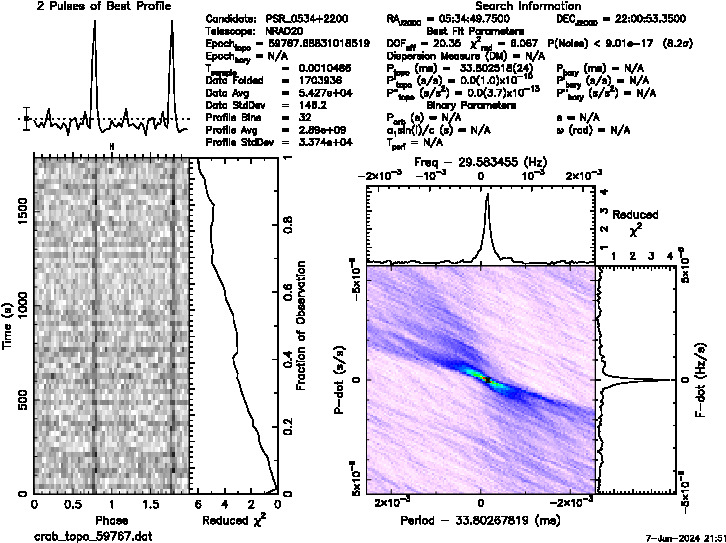

In [5]:
#Display the image
from IPython.display import display, Image
!convert -rotate 90 crab_topo_59767_PSR_0534+2200.pfd.ps crab_topo_59767_PSR_0534+2200.pfd.jpg
Image(filename='./crab_topo_59767_PSR_0534+2200.pfd.jpg')


### 2.2 Refolding with best period found above and -nosearch flag
In order to extract TOAs, we cannot use the -search option as we did above. The particular command that generates TOAs (see at bottom of notebook) requires the -nosearch option. So we use the best found period available in the .bestprof file that is generated from 2.1. and run again with the -nosearch flag. 

In [6]:
#Now run with the period in the crab_topo_59767_PSR_0534+2200.pfd.bestprof file and run with nosearch (get_toas requires this flag) 
!prepfold -p 0.033802518313215 -mask crab_59767_rfifind.mask -nosearch -nopdsearch crab_topo_59767.dat
#to see all available flags, use the following line
#!prepfold -h




        Pulsar Raw-Data Folding Search Routine
 Used for DM, Period, and P-dot tweaking of PSR candidates.
                 by Scott M. Ransom

Assuming the data are PRESTO time series of floats format...
Reading input data from 'crab_topo_59767.dat'.
Reading information from 'crab_topo_59767.inf'.

Folding a 33.80ms_Cand candidate.

Output data file is 'crab_topo_59767_33.80ms_Cand.pfd'.
Output plot file is 'crab_topo_59767_33.80ms_Cand.pfd.ps'.
Best profile is in  'crab_topo_59767_33.80ms_Cand.pfd.bestprof'.

Folding (topo) epoch  (MJD)  =  59767.688310185185
Data pt duration (dt)   (s)  =  0.001048576
Total number of data points  =  1703936
Number of profile bins       =  32
Folding period          (s)  =  0.033802518313215
Folding frequency      (hz)  =  29.5835946521

Starting work on 'crab_topo_59767.dat'...

  Folded 1703936 points of 1703936

Optimizing...

  Searching 1 periods, and 1 p-dots...
     (1 total trials)
  Amount Complete = 1664100%  Done searching. Complete = 15

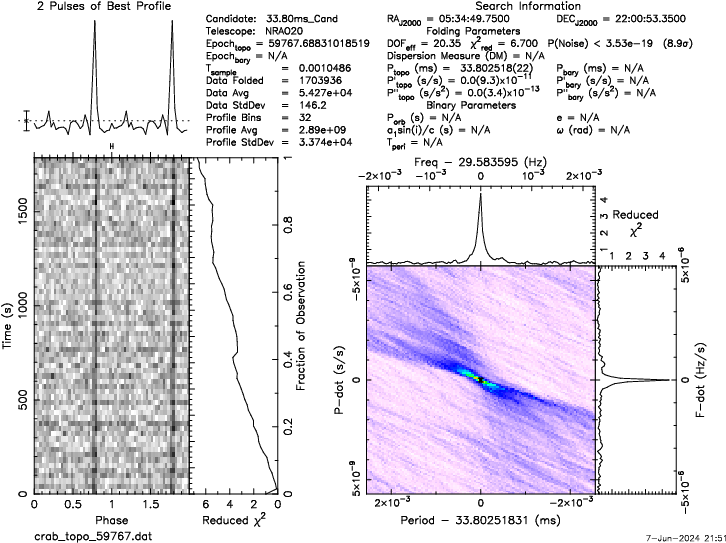

In [7]:
#Display the updated prepfold plot
from IPython.display import display, Image
!convert -rotate 90 crab_topo_59767_33.80ms_Cand.pfd.ps crab_topo_59767_33.80ms_Cand.pfd.png
Image(filename='./crab_topo_59767_33.80ms_Cand.pfd.png')

The -nosearch prepfold plot may look different than the original one. Ensure that there is still a strong detection. If there is not, then we likewise skip this observation. The strength of the signal determines how many TOAs we generate in section 3.1 below. See https://hosting.astro.cornell.edu/~shami/psrintro/papers/PSR_timing_beginner_guide.pdf for a useful figure that details how many TOAs you can extract given signal strength. TL:DR; a weaker signal will get you less TOAs.

## 3. Extracting TOAs

### 3.1. TOAs
You will need the get_TOAs.py program, included in this directory. You will also need the crab_template profile either from our directory or of your own generation (we recommend your own to suit your particular needs). 

#### `!get_TOAs.py -t template.bestprof -n (# TOAs) topofilename.pfd > (write to) filename.tim`


In [15]:
# APPENDING: after the first use of naming a .tim file (using one ">"), use ">> filename.tim" to append your TOAs to the file instead of overwriting it every time

#TOA amount options: 1,2,4,8,16...we generally limit to 8 or less.
!~/work/shared/PSC/advancedtiming/2023/get_TOAs.py -t crab_template.bestprof -n 4 crab_topo_59767_33.80ms_Cand.pfd > 59767_TOAs_new.tim

#!~/work/shared/PSC/advancedtiming/2023/get_TOAs.py -t crab_topo_0.40-1.00_33.80ms_Cand.pfd.bestprof -n 8 crab_topo_0.40-1.00_33.80ms_Cand.pfd >> crabTOAsMae.tim

Display the generated TOAs. The left column is the center frequency of the telescope. The middle is the actual TOA. The rightmost column is the associated error. For our purposes, we ideally like to see under 100. If you see higher error than that, decrease the amount of TOAs.

In [16]:
less 59767_TOAs_new.tim